In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
import catboost
from bayes_opt import BayesianOptimization

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data = pd.read_csv('./data/train.csv')
data

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,...,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,9,No,0,30,No,5-Low,Other,Other,No


In [3]:
data = data.dropna().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 49752 non-null  int64  
 1   Churn                      49752 non-null  object 
 2   MonthlyRevenue             49752 non-null  float64
 3   MonthlyMinutes             49752 non-null  float64
 4   TotalRecurringCharge       49752 non-null  float64
 5   DirectorAssistedCalls      49752 non-null  float64
 6   OverageMinutes             49752 non-null  float64
 7   RoamingCalls               49752 non-null  float64
 8   PercChangeMinutes          49752 non-null  float64
 9   PercChangeRevenues         49752 non-null  float64
 10  DroppedCalls               49752 non-null  float64
 11  BlockedCalls               49752 non-null  float64
 12  UnansweredCalls            49752 non-null  float64
 13  CustomerCareCalls          49752 non-null  flo

In [16]:
data.loc[:, (data.dtypes != object)].columns[1]

'MonthlyRevenue'

CallForwardingCalls, 25까지 확인 필요
UniqueSubs
ServiceArea

In [76]:
sns.countplot(
    data,
    x = data.loc[:, (data.dtypes == object)].columns[23],
    hue= "Churn"
)

IndexError: index 23 is out of bounds for axis 0 with size 23

In [4]:
data = data.drop(columns=['CustomerID']).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      49752 non-null  object 
 1   MonthlyRevenue             49752 non-null  float64
 2   MonthlyMinutes             49752 non-null  float64
 3   TotalRecurringCharge       49752 non-null  float64
 4   DirectorAssistedCalls      49752 non-null  float64
 5   OverageMinutes             49752 non-null  float64
 6   RoamingCalls               49752 non-null  float64
 7   PercChangeMinutes          49752 non-null  float64
 8   PercChangeRevenues         49752 non-null  float64
 9   DroppedCalls               49752 non-null  float64
 10  BlockedCalls               49752 non-null  float64
 11  UnansweredCalls            49752 non-null  float64
 12  CustomerCareCalls          49752 non-null  float64
 13  ThreewayCalls              49752 non-null  flo

In [5]:
label_encoders = {}
for column in ('Churn','ServiceArea', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode','Occupation', 'MaritalStatus'):
    label_encoder = LabelEncoder()
    data.loc[:, column] = label_encoder.fit_transform(data[column])

    label_encoders.update({column: label_encoder})

In [6]:
data = data.astype(dict(zip(np.extract(data.dtypes == object , data.columns), ['float']*23)))

In [44]:
data.corr().Churn.CurrentEquipmentDays

0.10251343117675969

In [46]:
new = data.filter(['CurrentEquipmentDays','Churn','ServiceArea'])

In [47]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CurrentEquipmentDays  49752 non-null  float64
 1   Churn                 49752 non-null  float64
 2   ServiceArea           49752 non-null  float64
dtypes: float64(3)
memory usage: 1.1 MB


In [51]:
new.corr()


,CurrentEquipmentDays,Churn,ServiceArea
CurrentEquipmentDays,1.000000,0.102513,0.011455
Churn,0.102513,1.000000,0.003104
ServiceArea,0.011455,0.003104,1.000000


In [53]:
n_train, n_test = train_test_split(new, test_size=0.2, random_state=0)

In [55]:
n_train

,CurrentEquipmentDays,Churn,ServiceArea
15674,568.0,0.0,129.0
2906,1024.0,0.0,588.0
27019,415.0,1.0,713.0
7168,821.0,1.0,734.0
19779,9.0,1.0,208.0
...,...,...,...
21243,462.0,0.0,334.0
45891,43.0,1.0,408.0
42613,294.0,1.0,396.0
43567,61.0,0.0,630.0


In [60]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(n_train.drop(columns=['Churn']), n_train.Churn)

print(f'train_acc: {((random_forest.predict(n_train.drop(columns=["Churn"]))) == n_train.Churn).mean()}')

print(
    classification_report(
        n_train.Churn,
        random_forest.predict(n_train.drop(columns=['Churn'])),
    )
)
print('*'*30)
print(
    confusion_matrix(
     n_train.Churn,
        random_forest.predict(n_train.drop(columns=['Churn'])),
)
)

print(f"acc: {(random_forest.predict(n_test.drop(columns=['Churn'])) == n_test.Churn).mean()}")

print(
    classification_report(
        n_test.Churn,
        random_forest.predict(n_test.drop(columns=['Churn'])),
    )
)
print('*'*30)
print(
    confusion_matrix(
     n_test.Churn,
        random_forest.predict(n_test.drop(columns=['Churn'])),
)
)

train_acc: 0.9438958820130148
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     28422
         1.0       0.94      0.86      0.90     11379

    accuracy                           0.94     39801
   macro avg       0.94      0.92      0.93     39801
weighted avg       0.94      0.94      0.94     39801

******************************
[[27791   631]
 [ 1602  9777]]
acc: 0.6434529193045925
              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76      7085
         1.0       0.34      0.24      0.28      2866

    accuracy                           0.64      9951
   macro avg       0.53      0.52      0.52      9951
weighted avg       0.61      0.64      0.62      9951

******************************
[[5709 1376]
 [2172  694]]


In [36]:
data.describe()

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,...,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000,49752.000000
mean,58.717374,525.021466,46.834961,0.891841,39.754040,1.226327,-11.656175,-1.175937,6.010556,4.077814,...,1.805093,1.558711,380.020843,31.338258,21.147592,0.035496,0.018331,0.051475,4.402677,0.053686
std,44.317244,528.510155,23.759492,2.224725,96.091606,9.848360,255.858193,39.392124,9.036653,10.836468,...,1.330834,0.906256,252.290072,22.091593,23.926589,0.201964,0.142854,0.266490,3.110498,0.382677
min,-6.170000,0.000000,-6.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,0.000000,...,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.610000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.000000,0.700000,0.000000,...,1.000000,1.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,48.380000,366.000000,45.000000,0.250000,3.000000,0.000000,-5.000000,-0.300000,3.000000,1.000000,...,1.000000,1.000000,330.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,70.910000,722.000000,60.000000,0.990000,40.000000,0.300000,65.000000,1.600000,7.700000,3.700000,...,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,1223.380000,7359.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,324.700000,...,24.000000,15.000000,1812.000000,99.000000,99.000000,4.000000,3.000000,16.000000,9.000000,25.000000


0, 200

In [24]:
data.loc[:, (data.dtypes != 'category')].columns

Index(['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'RetentionCalls', 'RetentionOffersAccepted',
       'ReferralsMadeBySubscriber', 'IncomeGroup',
       'AdjustmentsToCreditRating'],
      dtype='object')

In [7]:
Ex_data = data.MonthlyRevenue

mean = np.mean(Ex_data)

std = np.std(Ex_data)

print('데이터의 평균은', mean)

print('데이터의 표준 편차는', std)

데이터의 평균은 58.71737377391863
데이터의 표준 편차는 44.3167984395063


In [13]:
threshold = 3

outlier = [] 

for i in Ex_data: 
    z = (i-mean)/std 
    if z > threshold: 
        outlier.append(i) 
outlier.sort()
outlier

[191.79,
 191.84,
 191.91,
 191.96,
 191.99,
 192.01,
 192.36,
 192.43,
 192.53,
 192.58,
 192.6,
 192.73,
 192.77,
 192.78,
 192.78,
 192.84,
 192.91,
 192.99,
 193.06,
 193.07,
 193.11,
 193.36,
 193.39,
 193.53,
 193.59,
 193.62,
 193.69,
 193.78,
 193.78,
 193.9,
 193.91,
 193.94,
 194.19,
 194.21,
 194.22,
 194.4,
 194.48,
 194.5,
 194.51,
 194.56,
 194.64,
 194.69,
 194.74,
 194.88,
 194.9,
 195.01,
 195.13,
 195.16,
 195.24,
 195.28,
 195.29,
 195.57,
 195.72,
 195.75,
 195.75,
 195.79,
 195.83,
 195.84,
 195.86,
 195.89,
 195.91,
 196.04,
 196.04,
 196.28,
 196.29,
 196.29,
 196.4,
 196.4,
 196.41,
 196.43,
 196.43,
 196.47,
 196.54,
 196.57,
 196.61,
 196.76,
 196.78,
 196.85,
 196.96,
 197.08,
 197.09,
 197.35,
 197.4,
 197.53,
 197.65,
 197.66,
 197.75,
 197.8,
 197.88,
 197.91,
 197.93,
 198.01,
 198.04,
 198.11,
 198.12,
 198.25,
 198.35,
 198.58,
 198.76,
 198.79,
 198.79,
 198.82,
 199.01,
 199.09,
 199.18,
 199.5,
 199.58,
 199.67,
 199.69,
 199.7,
 199.71,
 199.99,
 20

<Axes: >

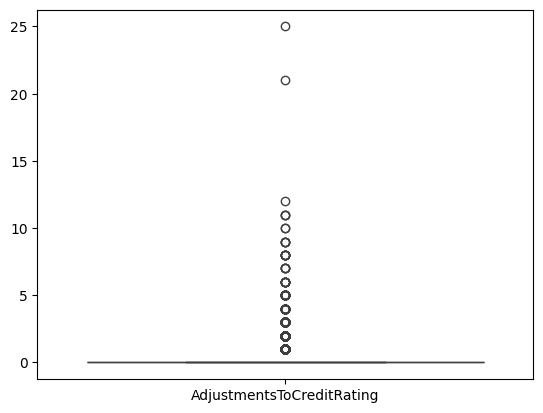

In [31]:
sns.boxplot(
    data.loc[:, (data.dtypes != 'category')].iloc[:, [33]],
)

In [24]:
data = data.query('`MonthlyRevenue` < 200 \
                  and `MonthlyMinutes` < 2000 \
                  and `TotalRecurringCharge` < 110 \
                  and `DirectorAssistedCalls` < 10 \
                  and `OverageMinutes` < 100 \
                  and `RoamingCalls` < 5 \
                  and -2000 <= `PercChangeMinutes` <= 2000 \
                  and -500 <= `PercChangeRevenues` <= 500 \
                  and `DroppedCalls` < 25 \
                  and `BlockedCalls` < 25 \
                  and `UnansweredCalls` < 100 \
                  and `CustomerCareCalls` < 25 \
                  and `ThreewayCalls` < 5 \
                  and `ReceivedCalls` < 500 \
                  and `OutboundCalls` < 100 \
                  and `InboundCalls` < 25 \
                  and `PeakCallsInOut` < 300 \
                  and `OffPeakCallsInOut` < 300 \
                  and `DroppedBlockedCalls` < 50 \
                  and `CallForwardingCalls` < 5 \
                  and `CallWaitingCalls` < 50 \
                  and `MonthsInService` < 50 \
                  and `UniqueSubs` < 25 \
                  and `ActiveSubs` < 15 \
                  and `Handsets` < 10 \
                  and `HandsetModels` < 8 \
                  and `CurrentEquipmentDays` < 1250 \
                  and `RetentionCalls` < 1'
                )

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34617 entries, 79 to 49749
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Churn                      34617 non-null  category
 1   MonthlyRevenue             34617 non-null  float64 
 2   MonthlyMinutes             34617 non-null  float64 
 3   TotalRecurringCharge       34617 non-null  float64 
 4   DirectorAssistedCalls      34617 non-null  float64 
 5   OverageMinutes             34617 non-null  float64 
 6   RoamingCalls               34617 non-null  float64 
 7   PercChangeMinutes          34617 non-null  float64 
 8   PercChangeRevenues         34617 non-null  float64 
 9   DroppedCalls               34617 non-null  float64 
 10  BlockedCalls               34617 non-null  float64 
 11  UnansweredCalls            34617 non-null  float64 
 12  CustomerCareCalls          34617 non-null  float64 
 13  ThreewayCalls              34617 no

In [7]:
train, temp = train_test_split(data, test_size=0.4, random_state=0)
valid, test = train_test_split(temp, test_size=0.5, random_state=0)

In [13]:
lgbm = lightgbm.LGBMClassifier(random_state=0)

lgbm.fit(train.drop(columns=['Churn']), train.Churn,
          eval_set= [(valid.drop(columns=['Churn']), valid['Churn'])],
        )


LGBMClassifier(random_state=0)

In [14]:
lgbm.score(test.drop(columns=['Churn']), test['Churn'])

0.7263591598834288

In [15]:
lgbm = lightgbm.LGBMClassifier(verbose = 0, random_state=0)
# from scipy.stats import uniform

parameters = {
    'max_depth': range(1, 201),
    'n_estimators': range(1, 201),
    }

random_search = RandomizedSearchCV(lgbm, parameters, random_state=0, scoring='accuracy')
random_search.fit(train.drop(columns=['Churn']), train.Churn)

RandomizedSearchCV(estimator=LGBMClassifier(random_state=0, verbose=0),
                   param_distributions={'max_depth': range(1, 201),
                                        'n_estimators': range(1, 201)},
                   random_state=0, scoring='accuracy')

In [16]:
best_lgbm = lightgbm.LGBMClassifier(
    random_state=0,
    n_estimators= random_search.best_params_.get('n_estimators'),
    max_depth= random_search.best_params_.get('max_depth')
)

best_lgbm.fit(train.drop(columns=['Churn']), train['Churn'],
        eval_set= [(valid.drop(columns=['Churn']), valid['Churn'])],
        
        )

best_lgbm.score(test.drop(columns=['Churn']), test['Churn'])

0.7255552205808461

In [17]:
print(
    classification_report(
        test.Churn,
        best_lgbm.predict(test.drop(columns=['Churn'])),
    ),
    confusion_matrix(
    test.Churn,
    best_lgbm.predict(test.drop(columns=['Churn'])),
)
)

              precision    recall  f1-score   support

         0.0       0.74      0.96      0.83      7126
         1.0       0.57      0.13      0.21      2825

    accuracy                           0.73      9951
   macro avg       0.65      0.55      0.52      9951
weighted avg       0.69      0.73      0.66      9951
 [[6853  273]
 [2458  367]]


In [52]:
confusion_matrix(
    test.Churn,
    best_lgbm.predict(test.drop(columns=['Churn'])),
)

array([[4826,  148],
       [1787,  163]], dtype=int64)

In [25]:
column = ('Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'DirectorAssistedCalls',
       'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes',
       'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls',
       'CustomerCareCalls', 'ThreewayCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'ActiveSubs', 'ServiceArea',
       'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'RVOwner',
       'BuysViaMailOrder', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer',
       'RetentionOffersAccepted', 'NewCellphoneUser', 'NotNewCellphoneUser',
       'ReferralsMadeBySubscriber', 'OwnsMotorcycle',
       'AdjustmentsToCreditRating', 'HandsetPrice', 'CreditRating',
       'PrizmCode', 'Occupation', 'MaritalStatus')

In [26]:
new_data = data.loc[:, column]

In [27]:
train, temp = train_test_split(new_data, test_size=0.4, random_state=0)
valid, test = train_test_split(temp, test_size=0.5, random_state=0)

In [62]:
lgbm = lightgbm.LGBMClassifier(random_state=0)

lgbm.fit(train.drop(columns=['Churn']), train.Churn,
          eval_set= [(valid.drop(columns=['Churn']), valid['Churn'])],
        )


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


LGBMClassifier(random_state=0)

In [63]:
lgbm.score(test.drop(columns=['Churn']), test['Churn'])

0.7183708838821491

In [64]:
lgbm = lightgbm.LGBMClassifier(verbose = 0, random_state=0)
# from scipy.stats import uniform

parameters = {
    'max_depth': range(1, 201),
    'n_estimators': range(1, 201),
    }

random_search = RandomizedSearchCV(lgbm, parameters, random_state=0, scoring='accuracy')
random_search.fit(train.drop(columns=['Churn']), train.Churn)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured

RandomizedSearchCV(estimator=LGBMClassifier(random_state=0, verbose=0),
                   param_distributions={'max_depth': range(1, 201),
                                        'n_estimators': range(1, 201)},
                   random_state=0, scoring='accuracy')

In [65]:
best_lgbm = lightgbm.LGBMClassifier(
    random_state=0,
    n_estimators= random_search.best_params_.get('n_estimators'),
    max_depth= random_search.best_params_.get('max_depth')
)

best_lgbm.fit(train.drop(columns=['Churn']), train['Churn'],
        eval_set= [(valid.drop(columns=['Churn']), valid['Churn'])],
        
        )

best_lgbm.score(test.drop(columns=['Churn']), test['Churn'])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


0.7219815135759676

In [28]:
data = data.astype(dict(zip(np.extract(data.dtypes == 'category' , data.columns), ['float']*23)))

In [29]:
new_data = data.loc[:, column]

In [30]:
train, temp = train_test_split(new_data, test_size=0.4, random_state=0)
valid, test = train_test_split(temp, test_size=0.5, random_state=0)

In [18]:
xgboost = xgb.XGBClassifier(random_state = 0)
xgboost.fit(train.drop(columns=['Churn']), train['Churn'],
        eval_set= [(valid.drop(columns=['Churn']), valid['Churn'])],
        
        )

xgboost.score(test.drop(columns=['Churn']), test['Churn'])

[0]	validation_0-logloss:0.59215
[1]	validation_0-logloss:0.58390
[2]	validation_0-logloss:0.57985
[3]	validation_0-logloss:0.57764
[4]	validation_0-logloss:0.57572
[5]	validation_0-logloss:0.57315
[6]	validation_0-logloss:0.57191
[7]	validation_0-logloss:0.57176
[8]	validation_0-logloss:0.57147
[9]	validation_0-logloss:0.57053
[10]	validation_0-logloss:0.56911
[11]	validation_0-logloss:0.56949
[12]	validation_0-logloss:0.56940
[13]	validation_0-logloss:0.56953
[14]	validation_0-logloss:0.56919
[15]	validation_0-logloss:0.56915
[16]	validation_0-logloss:0.56897
[17]	validation_0-logloss:0.56883
[18]	validation_0-logloss:0.56860
[19]	validation_0-logloss:0.56905
[20]	validation_0-logloss:0.56939
[21]	validation_0-logloss:0.56996
[22]	validation_0-logloss:0.57018
[23]	validation_0-logloss:0.56995
[24]	validation_0-logloss:0.57041
[25]	validation_0-logloss:0.57078
[26]	validation_0-logloss:0.57083
[27]	validation_0-logloss:0.57117
[28]	validation_0-logloss:0.57187
[29]	validation_0-loglos

0.7157069641242086

In [19]:
xgboost = xgb.XGBClassifier(random_state = 0)
# from scipy.stats import uniform

parameters = {
    'max_depth': range(1, 201),
    'n_estimators': range(1, 201),
    }

random_search = RandomizedSearchCV(xgboost, parameters, random_state=0, scoring='accuracy')
random_search.fit(train.drop(columns=['Churn']), train.Churn)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   param_distributions={'max_depth': range(1, 201),
                                        'n_estimators': range(1, 201)},
                   random_state=0, scoring='accuracy')

In [20]:
best_xgboost = xgb.XGBClassifier(
    random_state=0,
    n_estimators= random_search.best_params_.get('n_estimators'),
    max_depth= random_search.best_params_.get('max_depth')
)

best_xgboost.fit(train.drop(columns=['Churn']), train['Churn'],
        eval_set= [(valid.drop(columns=['Churn']), valid['Churn'])],
        
        )

best_xgboost.score(test.drop(columns=['Churn']), test['Churn'])

[0]	validation_0-logloss:0.60112
[1]	validation_0-logloss:0.60080
[2]	validation_0-logloss:0.60494
[3]	validation_0-logloss:0.61023
[4]	validation_0-logloss:0.61640
[5]	validation_0-logloss:0.61905
[6]	validation_0-logloss:0.62345
[7]	validation_0-logloss:0.62792
[8]	validation_0-logloss:0.63288
[9]	validation_0-logloss:0.63876
[10]	validation_0-logloss:0.64284
[11]	validation_0-logloss:0.64659
[12]	validation_0-logloss:0.65141
[13]	validation_0-logloss:0.65574
[14]	validation_0-logloss:0.66047
[15]	validation_0-logloss:0.66407
[16]	validation_0-logloss:0.66809
[17]	validation_0-logloss:0.67185
[18]	validation_0-logloss:0.67505
[19]	validation_0-logloss:0.67860
[20]	validation_0-logloss:0.68166
[21]	validation_0-logloss:0.68458
[22]	validation_0-logloss:0.68714
[23]	validation_0-logloss:0.68997
[24]	validation_0-logloss:0.69285
[25]	validation_0-logloss:0.69631
[26]	validation_0-logloss:0.69883
[27]	validation_0-logloss:0.70209
[28]	validation_0-logloss:0.70459
[29]	validation_0-loglos

0.7108833283087127

In [21]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(train.drop(columns=['Churn']), train['Churn']
        )

random_forest.score(test.drop(columns=['Churn']), test['Churn'])

0.7211335544166415

In [23]:
random_forest = RandomForestClassifier(random_state = 0)
# from scipy.stats import uniform

parameters = {
    'max_depth': range(1, 201),
    'n_estimators': range(1, 201),
    }

random_search = RandomizedSearchCV(random_forest, parameters, random_state=0, scoring='accuracy')
random_search.fit(train.drop(columns=['Churn']), train.Churn)

KeyboardInterrupt: 

In [77]:
best_random_forest = RandomForestClassifier(
    random_state=0,
    n_estimators= random_search.best_params_.get('n_estimators'),
    max_depth= random_search.best_params_.get('max_depth')
)

best_random_forest.fit(train.drop(columns=['Churn']), train['Churn'],
        
        )

best_random_forest.score(test.drop(columns=['Churn']), test['Churn'])

0.7238590410167534

In [80]:
print(
    classification_report(
        test.Churn,
        best_random_forest.predict(test.drop(columns=['Churn'])),
    ),

    confusion_matrix(
        test.Churn,
        best_random_forest.predict(test.drop(columns=['Churn'])),
    )
)

              precision    recall  f1-score   support

         0.0       0.73      0.99      0.84      4974
         1.0       0.63      0.05      0.09      1950

    accuracy                           0.72      6924
   macro avg       0.68      0.52      0.46      6924
weighted avg       0.70      0.72      0.63      6924
 [[4920   54]
 [1858   92]]


In [82]:
svc = SVC(random_state=0)
svc.fit(train.drop(columns=['Churn']), train['Churn']
        )
svc.score(test.drop(columns=['Churn']), test['Churn'])

0.7183708838821491

In [31]:
train

,Churn,MonthlyRevenue,MonthlyMinutes,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,CreditRating,PrizmCode,Occupation,MaritalStatus
9848,1.0,35.24,32.0,0.25,0.0,0.0,70.0,-0.2,0.0,0.0,...,0.0,0.0,0,0.0,0,15.0,1.0,3.0,4.0,2.0
15385,1.0,17.39,8.0,0.00,1.0,0.0,4.0,0.0,0.0,0.0,...,1.0,0.0,0,0.0,0,15.0,1.0,2.0,4.0,2.0
23500,0.0,58.06,511.0,0.50,49.0,0.0,230.0,-23.1,2.0,4.0,...,1.0,0.0,0,0.0,0,15.0,1.0,2.0,4.0,2.0
41129,0.0,9.84,101.0,0.00,0.0,0.0,-20.0,-0.3,0.7,1.0,...,1.0,0.0,0,0.0,0,15.0,0.0,0.0,3.0,2.0
20370,0.0,36.97,122.0,1.98,0.0,0.0,22.0,-1.0,2.3,2.0,...,0.0,0.0,0,0.0,0,15.0,1.0,2.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29637,1.0,50.80,1032.0,0.25,0.0,0.0,140.0,-0.5,3.3,18.3,...,0.0,1.0,0,0.0,0,15.0,1.0,0.0,3.0,2.0
45887,1.0,70.09,688.0,0.50,62.0,1.3,-198.0,-18.1,4.3,4.0,...,0.0,0.0,0,0.0,0,15.0,3.0,0.0,4.0,2.0
43257,0.0,37.20,767.0,0.99,4.0,0.0,-6.0,0.2,2.0,0.3,...,1.0,0.0,0,0.0,0,14.0,1.0,0.0,3.0,2.0
30343,0.0,50.48,284.0,0.50,0.0,0.0,230.0,1.5,1.3,0.7,...,0.0,0.0,0,0.0,0,15.0,1.0,0.0,3.0,0.0


In [24]:
base_learners = [
  ("model1", lightgbm.LGBMClassifier(
      random_state=0,
      n_estimators=31,
      max_depth=78,
      verbose=0
    )
  ),
  ("model2", xgb.XGBClassifier(
      random_state=0,
      n_estimators=90,
      max_depth=86,
      verbose=0
    )
  ),
  ("model3", RandomForestClassifier(
      max_depth=14, 
      n_estimators=133, 
      random_state=0
    )
  ),
]
meta_learner = SVC(random_state= 0,)

stacking_classifier = StackingClassifier(
  estimators=base_learners,
  final_estimator=meta_learner,
)

stacking_classifier.fit(train.drop(columns=["Churn"]), train["Churn"])    # train
stacking_classifier.predict(test.drop(columns=["Churn"]))


c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [14:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaco

array([0., 0., 1., ..., 0., 0., 0.])

In [25]:
print(f'stacking_classifier acc: {(stacking_classifier.predict(test.drop(columns=["Churn"])) == test["Churn"]).mean()}')

stacking_classifier acc: 0.7224399557833383


In [36]:
voting_classifier = VotingClassifier(
    [(f'model{i+1}', StackingClassifier(estimators=base_learners, final_estimator=meta_learner)) for i in range(10)]
)

voting_classifier.fit(train.drop(columns=['Churn']), train['Churn'])

(voting_classifier.predict(test.drop(columns=['Churn'])) == test['Churn']).mean()

c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [05:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [05:04:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [05:04:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\USER\anaco

0.726891969959561

In [26]:
voting_classifier = VotingClassifier(
    estimators=[
        ("model1", lightgbm.LGBMClassifier(
      random_state=0,
      n_estimators=31,
      max_depth=78,
      verbose=0
    )
  ),
  ("model2", xgb.XGBClassifier(
      random_state=0,
      n_estimators=90,
      max_depth=86,
      verbose=0
    )
  ),
  ("model3", RandomForestClassifier(
      max_depth=14, 
      n_estimators=133, 
      random_state=0
    )
  ),
    ],
    voting='hard'  # 또는 'soft'를 사용해 확률 기반 투표 가능
)

voting_classifier.fit(train.drop(columns=['Churn']), train['Churn'])

(voting_classifier.predict(test.drop(columns=['Churn'])) == test['Churn']).mean()

c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


0.7237463571500352

In [27]:
print(
    classification_report(
        test.Churn,
        voting_classifier.predict(test.drop(columns=['Churn'])),
    ),

    confusion_matrix(
        test.Churn,
        voting_classifier.predict(test.drop(columns=['Churn'])),
    )
)

              precision    recall  f1-score   support

         0.0       0.73      0.99      0.84      7126
         1.0       0.65      0.06      0.11      2825

    accuracy                           0.72      9951
   macro avg       0.69      0.52      0.47      9951
weighted avg       0.70      0.72      0.63      9951
 [[7036   90]
 [2659  166]]
